Bienvenue dans cette seconde partie d'un tutoriel consacré à de la **cartographie statique mélangeant transfert de couleurs et astronomie**. 

Dans l'épisode précédent, nous avons réalisé un fond de carte à partir d'un assemblage de fichiers raster fournis par le Centre national d'information géographique espagnol, et personnalisé suivant un extrait de film de science-fiction.

Ce fond de carte est **désormais enregistré au format png**, et nous ne pouvons donc plus en tirer la moindre information géographique. Néanmoins, **voici les références principales** que nous avions notées :
* la projection du fond de carte est l'European Terrestrial Reference System 1989 (EPSG:25830)
* son cadre suit la structure x_lim = (-74125.16131267, 1131714.83868733) et y_lim = (4883505.0131369, 3870655.0131369503)

Cela nous suffira à ne pas nous emmêler les pinceaux lors de ce tutoriel. Nous allons désormais invoquer les modules utiles, et autant dire qu'ils sont nombreux :

In [1]:
import math, pyproj
import cv2 as cv
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import AltAz, EarthLocation, get_body
from astropy.time import Time
from astropy.units import deg, m
from datetime import datetime, timedelta, timezone
from matplotlib import patches
from matplotlib import text as mtext
from scipy.optimize import minimize
from shapely.geometry import LineString

## Récupération des éclipses passant au-dessus de l'Espagne

*nb : cette étape peut être évitée*

Vous aurez peut-être remarqué la présence d'Astropy, bibliothèque Python consacrée à l'astronomie [disposant d'une documentation pléthorique](https://learn.astropy.org/). Le développeur Erik Bernhardsson s'en est servi il n'y a pas si longtemps afin [de cibler et cartographier les prochaines éclipses solaires](https://erikbern.com/2024/04/07/predicting-solar-eclipses-with-python).

Son projet repose notamment sur les postulats suivants :
* **déterminer**, à une date donnée, **les degrés de séparation entre la lune et le soleil depuis la Terre**. Divulgâchage : si cette séparation égale ou s'approche beaucoup de zéro, nous pouvons conclure à une éclipse. **Les diamètres apparents de la lune et du soleil ne sont pas pris en compte**, et nous pouvons donc conclure que [cette fonction ratissera aussi bien les éclipses solaires totale qu'annulaires](https://www.lemonde.fr/les-decodeurs/article/2024/04/08/eclipse-solaire-totale-partielle-ou-annulaire-comment-ca-marche_5336493_4355772.html) (mais exclura les éclipses partielles)
* récupérer, entre deux dates, l'ensemble des points (projetés en World Geodetic System 1984) apparaissant à un intervalle défini par l'utilisateur, si la séparation entre la lune et soleil depuis la Terre est très proche de zéro
* cartographier chaque éclipse détectée dans des représentations en 3D, incluant la ligne principale de l'éclipse et différents horaires (UTC et local) de son passage

Seules les deux premières parties nous préoccupent, et les quelques fonctions impliquées pouvaient à vrai dire se simplifier **en utilisant des compréhension de listes et générateurs**. Bref, cela donne :

In [3]:
def gen_dts(dt_a: datetime, dt_b: datetime, sec_delta: float) -> list[datetime]:
  """
      Cette fonction retourne une liste de dates (AAAA,MM,JJ,HH,MM,SS) à partir de la différence de deux dates (une de départ, une d'arrivée) et d'un delta exprimé en secondes.
  """
  return [dt_a+timedelta(seconds=x) for x in range(0,(dt_b-dt_a).seconds,sec_delta)]

def sun_moon_separation(lat: float, lon: float, t: float) -> float:
    """
        Cette fonction renvoie, à une date de données la séparation en degrés entre la lune et le soleil depuis un plan horizontal ayant son origine sur Terre.
        Si cette séparation est égale ou très proche de zéro, une éclipse solaire a lieu.
    """
    loc = EarthLocation(lat=lat * deg, lon=lon * deg, height=0 * m)
    time = Time(t, format="unix")
    moon = get_body("moon", time, loc)
    sun = get_body("sun", time, loc)

    az = AltAz(obstime=time, location=loc)
    sun_az = sun.transform_to(az)
    moon_az = moon.transform_to(az)
    if sun_az.alt < 0 or moon_az.alt < 0:
        return 180

    sep = moon.separation(sun)
    return sep.deg

def find_eclipse_location(dt: datetime) -> tuple[datetime, float, float] | None:
  """
     A une date donnée, cette fonction renvoie un tuple composée d'une date, d'une latitude et d'une longitude (CRS 2346)
     si une éclipse solaire totale ou annulaire a lieu sur Terre.
     Si aucune éclipse n'a lieu, elle renvoie None.
  """
  t = datetime.timestamp(dt)
  fun = lambda x: sun_moon_separation(x[0], x[1], t)

  x0s = [
      (lat, lon)
      for lat in [-75, -45, -15, 15, 45, 75]
      for lon in [-150, -90, -30, 30, 90, 150]
      ]
  x0 = min(x0s, key=fun)

  ret = minimize(fun, bounds=[(-90, 90), (-180, 180)], x0=x0)

  if ret.fun < 1e-3:
    lat, lon = ret.x
    return (dt, lat, lon)
  else:
    return None

def data_eclipse(dt_min: datetime, dt_max: datetime,td_sec:int) -> dict:
    """
        Entre deux dates données (Temps universel coordonné largement conseillé), cette fonction renvoie un dictionnaire suivant le format :
        {date:[latitude,longitude],...} (coordonnées géographiques) si une éclipse se déroule aux dates considérées
    """
    dt_a = dt_min - timedelta(seconds=td_sec)
    dt_b = dt_max + timedelta(seconds=td_sec)
    print(f"Finding path of eclipse from {dt_a} to {dt_b}")
    el = [e for e in (find_eclipse_location(d) for d in gen_dts(dt_a, dt_b, td_sec)) if e is not None]
    dts = [t[0] for t in el]
    lats = [t[2] for t in el]
    lons = [t[1] for t in el]
    return {d:[lat,lon] for d, lon, lat in zip(dts, lons, lats)}

Dans le projet de référence, nous avançons à l'aveugle sans savoir si tel jour il y a une éclipse ou non, ce qui est coûteux en ressource et [justifie grandement le recours au parallélisme](https://realpython.com/python-concurrency/).

Mais dans notre cas, nous pouvons jouer aux petits malins en utilisant les infographies déjà réalisées par Bernhardsson afin **d'isoler les portions passant par l'Espagne**. La plus proche de la rédaction de ce calepin est par exemple [celle du 12 août 2026](https://viajes.nationalgeographic.com.es/lifestyle/cuando-donde-ver-proximo-eclipse-solar-total-espana_20316).

Son passage sur la péninsule durera moins de dix minutes, aussi nous pouvons grappiller des données toutes les cinq secondes comme suit :

In [15]:
esp_0826 = data_eclipse(datetime(2026, 8, 12, 18, 24, 0, tzinfo=timezone.utc),datetime(2026, 8, 12, 18, 32, 15, tzinfo=timezone.utc),5)

Finding path of eclipse from 2026-08-12 18:23:55+00:00 to 2026-08-12 18:32:20+00:00


Après quelques minutes de calcul, nous pouvons coder une fonction se servant du dictionnaire remis afin de **créer une GeoDataFrame digne de ce nom**, avec une belle ligne représentant le trajet du centre de l'éclipse :

In [4]:
def gdf_eclipse(eclipses:dict) -> gpd.geodataframe.GeoDataFrame:
  """
    Cette fonction renvoie, sous réserve d'avoir mis en unique attribut un dictionnaire valide renvoyé par data_eclipse(),
    une ligne géographique à partir des différents points contenus dans le dictionnaire.
  """
  try:
    eclipse_date = str(list(eclipses.keys())[0].day)+"/"+str(list(eclipses.keys())[0].month)+"/"+str(list(eclipses.keys())[0].year)
    DF = pd.DataFrame()
    DF["latitude"] = [v[0] for v in eclipses.values()]
    DF["longitude"] = [v[1] for v in eclipses.values()]
    GDF = gpd.GeoDataFrame(columns=["date"],crs='epsg:4326', geometry=[LineString(DF.to_numpy())])
    GDF["date"] = eclipse_date
    return GDF
  except:
    print("Attention au format du dictionnaires d'éclipses ! Elle doit respecter la configuration suivante : {date0:[longitude0,latitude0],date1:[longitude1,latitude1],...}")

Nous pouvons désormais la déployer...

In [17]:
gdf_esp_0826 = gdf_eclipse(esp_0826)

...vérifier qu'elle est conforme à ce qui est attendu...

In [30]:
gdf_esp_0826

date                                           geometry
0  12/8/2026  LINESTRING (-10.11506 45.91756, -10.04618 45.8...

...et enfin la visualiser :

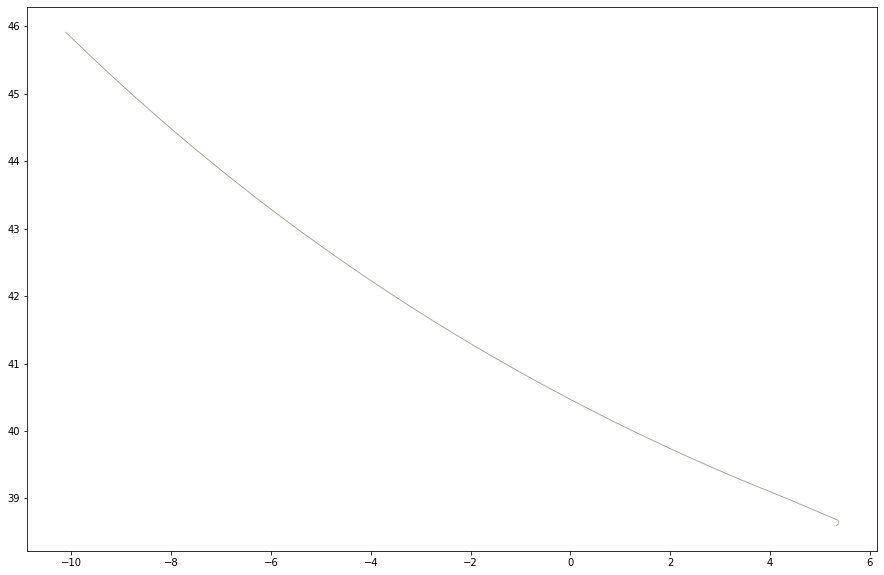

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
gdf_esp_0826.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94");

La ligne espérée est bien représentée, **mais il se peut que certains points dévient du schéma**. C'est par exemple le cas à la fin de la ligne.

Comme d'habitude, il y a plusieurs solutions permettant d'arriver au même résultat (une ligne bien propre). Première solution, observer les entrées du dico de référence :

In [19]:
esp_0826

{datetime.datetime(2026, 8, 12, 18, 23, 55, tzinfo=datetime.timezone.utc): [-10.11505927846848,
  45.9175602022618],
 datetime.datetime(2026, 8, 12, 18, 24, tzinfo=datetime.timezone.utc): [-10.046183594719663,
  45.86787805583584],
 datetime.datetime(2026, 8, 12, 18, 24, 5, tzinfo=datetime.timezone.utc): [-9.97684006091446,
  45.81807270565393],
 datetime.datetime(2026, 8, 12, 18, 24, 10, tzinfo=datetime.timezone.utc): [-9.907020274091057,
  45.76814206372966],
 datetime.datetime(2026, 8, 12, 18, 24, 15, tzinfo=datetime.timezone.utc): [-9.836719073822424,
  45.71808442305629],
 datetime.datetime(2026, 8, 12, 18, 24, 20, tzinfo=datetime.timezone.utc): [-9.76592501228088,
  45.6678971847709],
 datetime.datetime(2026, 8, 12, 18, 24, 25, tzinfo=datetime.timezone.utc): [-9.694633826915679,
  45.61757817828133],
 datetime.datetime(2026, 8, 12, 18, 24, 30, tzinfo=datetime.timezone.utc): [-9.622833736700365,
  45.5671250326773],
 datetime.datetime(2026, 8, 12, 18, 24, 35, tzinfo=datetime.timez

En cherchant les points qui dévient, nous constatons que **les trois derniers points dénotent du reste** : leur longitude diminuent au lieu d'augmenter. Nous pouvons alors préparer une liste de purge avec les trois dates concernées...

In [24]:
purge_points = list(esp_0826.keys())[-3:]
purge_points

[datetime.datetime(2026, 8, 12, 18, 32, 5, tzinfo=datetime.timezone.utc),
 datetime.datetime(2026, 8, 12, 18, 32, 10, tzinfo=datetime.timezone.utc),
 datetime.datetime(2026, 8, 12, 18, 32, 15, tzinfo=datetime.timezone.utc)]

...remettre à jour le dictionnaire de référence...

In [29]:
def_esp_0826 = {k:v for k,v in esp_0826.items() if k not in purge_points}

...et reconstruire la GeoDataFrame avant de l'enregistrer en geojson :

In [32]:
gdf_esp_0826 = gdf_eclipse(esp_0826)
gdf_esp_0826.to_file("data\\eclipse_0826.json",driver="GeoJSON")

**Autre solution : la factorisation**. Nous pourrions coder une fonction faisant les différences entre latitude et longitude, observer si ces dernières diminuent ou augmentent la plupart du temps et reconstruire la liste de purge depuis les valeurs aberrantes.

Mais, pour êter tout à fait honnête, lors des essais suivants je n'ai plus constaté d'aberration, et ne me suis donc pas attelé à cette fonction.

Bref, nous pouvons passer ensuite aux éclipses suivantes. Dans le détail des passages, Bernhardsson a conclus un peu vite sur les pays impactés **en se basant uniquement sur la ligne centrale des éclipses**. Or, l'ombre d'une éclipse fait plusieurs centaines de kilomètres de large, et il s'avère que le Sud de l'Espagne sera aussi couvert par une autre éclipse totale, le 2 août 2027.

Du coup, c'est reparti pour un tour (ou pas : les geojson de ces éclipses se trouvent dans le sous-dossier data de ce projet, et vous n'avez donc pas à refaire mouliner Astropy) :

In [8]:
esp_0827 = data_eclipse(datetime(2027, 8, 2, 8, 43, 0, tzinfo=timezone.utc),datetime(2027, 8, 2, 9, 1, 15, tzinfo=timezone.utc),5)

Finding path of eclipse from 2027-08-02 08:42:55+00:00 to 2027-08-02 09:01:20+00:00


C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Puis, nous transformons ce dico en GDF que nous visualisons.

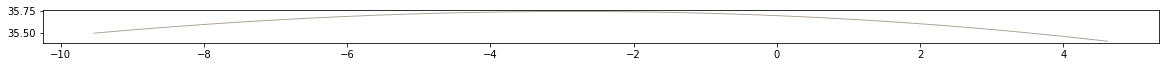

In [10]:
gdf_esp_0827 = gdf_eclipse(esp_0827)

fig, ax = plt.subplots(figsize=(20,10))
gdf_esp_0827.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94");

Le résultat est conforme, nous scellons donc ce travail avec un geojson :

In [11]:
gdf_esp_0827.to_file("data\\eclipse_0827.json",driver="GeoJSON")

Encore un petit effort pour l'éclipse du 26 janvier 2028...

In [33]:
esp_0128 = data_eclipse(datetime(2028, 1, 26, 16, 54, 0, tzinfo=timezone.utc),datetime(2028, 1, 26, 16, 58, 50, tzinfo=timezone.utc),5)

Finding path of eclipse from 2028-01-26 16:53:55+00:00 to 2028-01-26 16:58:55+00:00


C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


...que nous pouvons ensuite transformer et visualiser...

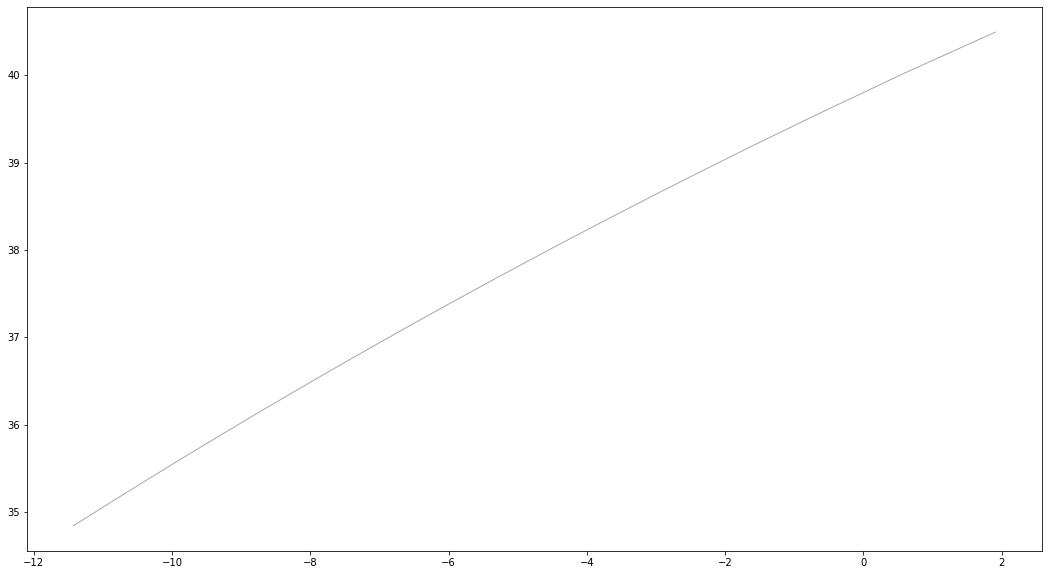

In [36]:
gdf_esp_0128 = gdf_eclipse(esp_0128)

fig, ax = plt.subplots(figsize=(20,10))

gdf_esp_0128.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94");

...et finalement enregistrer :

In [37]:
gdf_esp_0128.to_file("data\\eclipse_0128.json",driver="GeoJSON")

## Cartographie des ombres projetées

Nous pouvons gruger l'étape de constitution des GDF en chargeant directement les fichiers se trouvant dans le sous-dossier data. Pourquoi s'en priver ?

In [100]:
gdf_esp_0826 = gpd.read_file("data\\eclipse_0826.json")
gdf_esp_0827 = gpd.read_file("data\\eclipse_0827.json")
gdf_esp_0128 = gpd.read_file("data\\eclipse_0128.json")

A présent, nous allons nous atteler **à préparer des calques aux mêmes dimensions** que le fond de carte préparé dans la partie précédente.

Cela passe d'abord par une reprojection des trois trajets d'éclipse :

In [101]:
gdf_esp_0826 = gdf_esp_0826.to_crs("EPSG:25830")
gdf_esp_0827 = gdf_esp_0827.to_crs("EPSG:25830")
gdf_esp_0128 = gdf_esp_0128.to_crs("EPSG:25830")

Nous allons visualiser l'ensemble afin de nous assurer que rien ne dépasse :

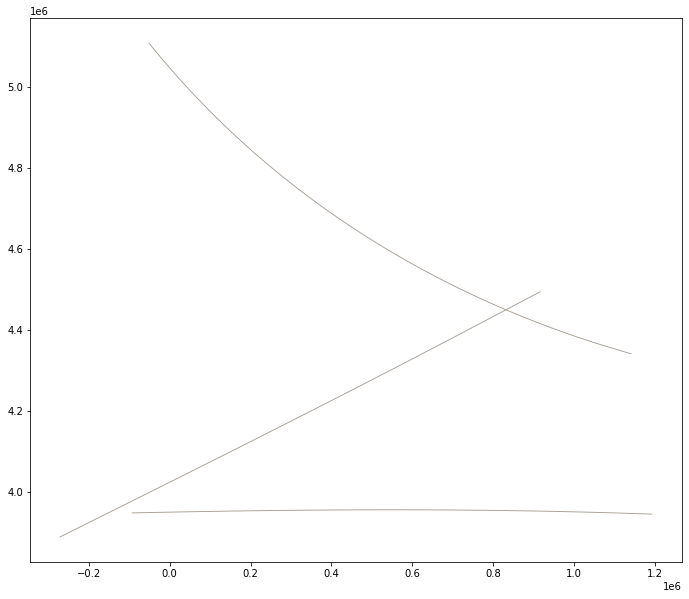

In [6]:
fig, ax = plt.subplots(figsize=(20,10))

gdf_esp_0826.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
gdf_esp_0827.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
gdf_esp_0128.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94");

Le système de coordonnées a bien été modifié et les lignes sont proches voisines, tout est parfait. Nous pouvons maintenant nous préoccuper de la largeur des ombres projetées. Pour verser dans l'euphémisme, cela nécessite [des calculs assez costauds](https://media4.obspm.fr/public/ressources_lu/pages_eclipses-soleil/geometrie-eclipses-soleil_impression.html), et à notre stade **nous allons plutôt recouper avec une source de référence** qui n'est autre que...la NASA.

Cette dernière fournit des listings arides (mais complets) sur les trajets de différentes éclipses, par exemples [celles du 26 août 2026](https://eclipse.gsfc.nasa.gov/SEpath/SEpath2001/SE2026Aug12Tpath.html), [du août 2027](https://eclipse.gsfc.nasa.gov/SEpath/SEpath2001/SE2027Aug02Tpath.html), ou encore [du 26 janvier 2028](https://eclipse.gsfc.nasa.gov/SEpath/SEpath2001/SE2028Jan26Apath.html).

Ces ressources sont non seulement précieuses pour recouper les informations géographiques trouvées avec Astropy (divulgâchage : c'est juste), **mais aussi pour avoir une estimation de l'ombre projetée** (la donnée supplémentaire qui nous intéresse) à différents horaires. 

Cela justifie bien une nouvelle fonction. Cette dernière va déformer la géométrie d'une GeoDataFrame (ici des lignes), **suivant le rayon d'un tampon exprimée en mètres.** Afin d'éviter de faire n'importe quoi avec des projections dont l'unité est le degré, nous allons installer un test afin d'éventuellement reprojeter la GDF :

In [102]:
def buffer_meters(GDF:gpd.geodataframe.GeoDataFrame,buffer_m:int) -> gpd.geodataframe.GeoDataFrame:
    """
        Cette fonction renvoie la géométrie d'une GeoDataFrame déformée suivant un tampon exprimée en mètre.
        Si jamais la DataFrame  de référence n'est pas inscrite dans des coordonnées dont l'unité est le mètre, on la convertit d'abord avant d'appliquer le tampon et de la reprojeter 
        au système de coordonnées initial.     
    """
    try:
        crs_ref = gdf_esp_0826.crs
        if crs_ref.axis_info[0].unit_name=="metre":
            GDF["geometry"] = GDF["geometry"].buffer(buffer_m)
        else:
            GDF = GDF.to_crs("EPSG:25830")
            GDF["geometry"] = GDF["geometry"].buffer(buffer_m)
            GDF = GDF.to_crs(crs_ref)
        return GDF
    except:
        print("Veillez à renseigner un ordre de grandeur en mètre valide et/ou à bien pointer une GeoDataFrame")

Pour chaque recoupement effectué avec les listings de la NASA, nous reteons **la largeur minimum de l'éclipse lors du passage cartographié** :
* 270 km en 2026
* 244 km en 2027
* 376 km en 2028

Et comme l'attribut est un rayon, on divise à chaque appel de fonction par deux :

In [103]:
gdf_esp_0826 = buffer_meters(gdf_esp_0826,135000)
gdf_esp_0827 = buffer_meters(gdf_esp_0827,122000)
gdf_esp_0128 = buffer_meters(gdf_esp_0128,178000)

Cartographions ces nouvelles GDF :

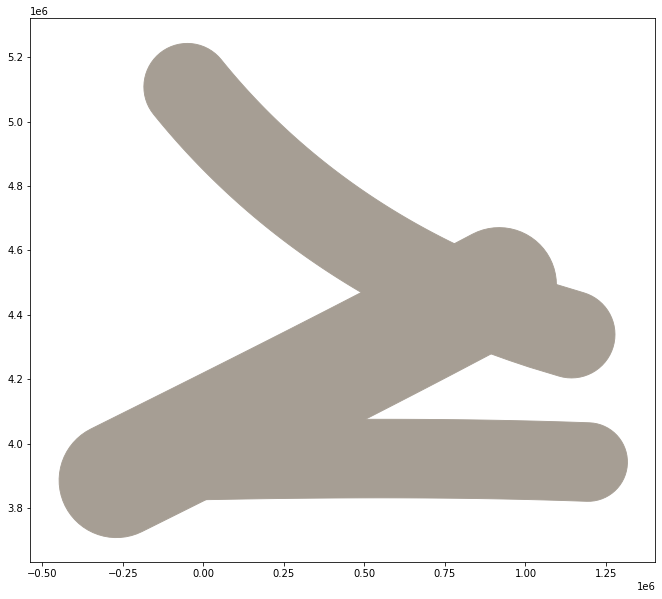

In [105]:
fig, ax = plt.subplots(figsize=(20,10))

gdf_esp_0826.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
gdf_esp_0827.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
gdf_esp_0128.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94");

C'est pas mal du tout, au point que nous allons recadrer suivant les bords de notre fond de carte :

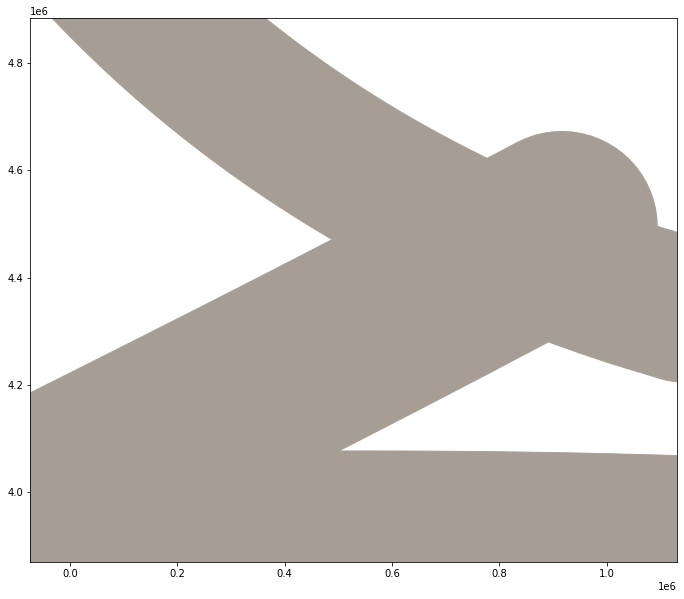

In [11]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_ylim(3870655.0131369503,4883505.01313695)
ax.set_xlim(-74125.16131267,1131704.83868733)
gdf_esp_0826.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
gdf_esp_0827.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
gdf_esp_0128.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94");

Comment personnaliser un peu plus ces trajets ? Superposer la date et le caractère de l'éclipse serait un plus enviable. Visuellement, **ce serait encore mieux si cette superposition suivant le trajet de l'éclipse**.

Cela n'a rien d'évident avec matplotlib, et il faut remercier certains développeur comme Tomas Kühn [de fournir des classes entières en réponses à des demandes StackOverflow](https://stackoverflow.com/questions/19353576/curved-text-rendering-in-matplotlib). Des années plus tard elle est encore parfaite, et je la reproduis donc telle quelle :

In [14]:
class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used

Nous allons recharger les trajets d'éclipses bien reprojetés, car ces derniers serviront de guides aux prochaines descriptions :

In [13]:
l_0826 = gpd.read_file("data\\eclipse_0826.json")
l_0827 = gpd.read_file("data\\eclipse_0827.json")
l_0128 = gpd.read_file("data\\eclipse_0128.json")
l_0826 = l_0826.to_crs("EPSG:25830")
l_0827 = l_0827.to_crs("EPSG:25830")
l_0128 = l_0128.to_crs("EPSG:25830")

Afin de coller à la classe CurvedText, nous devons fournir des tableau Numpy uniquement remplis de coordonnés X et Y. Il faut également **veiller à bien choisir les départ de ces coordonnées pour chaque éclipse**, car nous nous sommes laissés une marge de sûreté au-delà du fond de carte.

Magie de la lecture post-codage, vous n'avez absolument pas à vous en préoccuper :

In [48]:
dl_0826 = np.vstack(l_0826.iloc[0].geometry.coords.xy)[:,47:]
dl_0827 = np.vstack(l_0827.iloc[0].geometry.coords.xy)[:,39:]
dl_0128 = np.vstack(l_0128.iloc[0].geometry.coords.xy)[:,23:]

Plus qu'à ranger ces coordonnées dans une liste, et de paramétrer le texte des trois légendes :

In [49]:
l_eclipses = [dl_0826,dl_0827,dl_0128]
t_eclipses = ["Eclipse total del 12 de agosto de 2026","Eclipse total del 2 de agosto de 2027","Eclipse anular del 26 de enero de 2028"]

Nous n'avons plus qu'à dérouler avec matplotlib. Petites coquetteries : 
* **bien se conformer aux dimensions du fond de carte**. Cela passe par la commande plt.subplots(figsize=(12.058, 10.128), dpi=100,constrained_layout=True) puis au moment de la sauvegarde plt.savefig('data\\eclipsesp.png', dpi=1000, transparent=True). On aura donc pour la largeur 12.058 *  1000 en largeur et 10.128 * 1000 en hauteur. Soit les exactes dimensions du fond de carte
* **choisir une police de caractère au rendu** (un peu) machinique
* **diminuer l'opacité de l'éclipse annulaire** par rapport aux deux éclipses totales

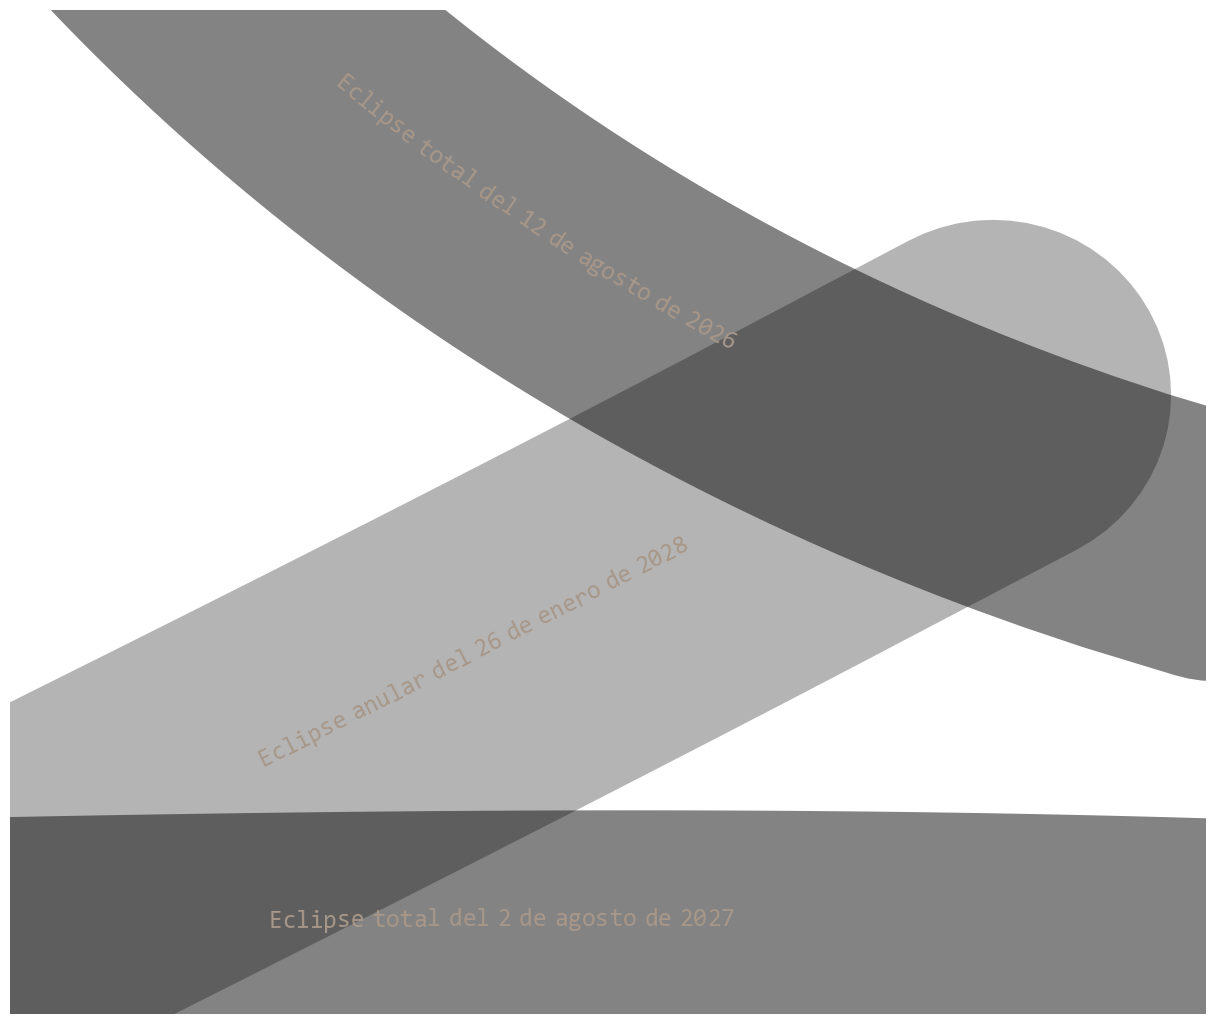

In [55]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Consolas'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default']

fig, ax = plt.subplots(figsize=(12.058, 10.128), dpi=100,constrained_layout=True)

ax.set_ylim(3870655.0131369503,4883505.01313695)
ax.set_xlim(-74125.16131267,1131704.83868733)
for d,t in zip(l_eclipses,t_eclipses):
    t_def = CurvedText(x = d[0],y = d[1],text=t, color="#A8988A", va = 'bottom',axes = ax,fontsize=18)
gdf_esp_0826.plot(ax=ax, color="#090808", alpha=.5,zorder=0)
gdf_esp_0827.plot(ax=ax, color="#090808", alpha=.5,zorder=0)
gdf_esp_0128.plot(ax=ax, color="#090808", alpha=.3,zorder=0)

ax.axis('off')
plt.savefig('data\\eclipsesp.png', dpi=1000, transparent=True);

## Calque des repères citadins

Nous approchons de la fin, mais il nous reste encore une petite chose à paramétrer. Le fond de carte précédent est nu, sans aucun contour adiministratif, et **ajouter quelques villes en guise de repères** ne serait pas de trop.

Le CNIG espagnol fournit un fichier géographique listant tous les contours communaux du pays. Celui peut se trouver à l'arborescence suivante [à partir de cette porte d'entrée](https://centrodedescargas.cnig.es/CentroDescargas/index.jsp#) :

Buscar < Búsqueda por listado < Información geográfica de referencia < Límites municipales, provinciales y autonómicos (División administrativa < Toda España)

Une fois l'unique fichier de résultat récupéré, vous devrez téléverser les fichiers commençant par recintos_municipales_inspire_peninbal_etrs89 dans le sous-dossier data afin de reproduire la manip suivante :

In [2]:
ciudades = gpd.read_file("data\\recintos_municipales_inspire_peninbal_etrs89.shp")
ciudades.tail()

INSPIREID COUNTRY  \
8127  ES.IGN.BDDAE.34025050266      ES   
8128  ES.IGN.BDDAE.34025050267      ES   
8129  ES.IGN.BDDAE.34074949118      ES   
8130  ES.IGN.BDDAE.34072424046      ES   
8131  ES.IGN.BDDAE.34074949178      ES   

                                                 NATLEV NATLEVNAME  \
8127  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
8128  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
8129  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
8130  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
8131  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   

          NATCODE                NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
8127  34025050266              Trasobares     ES2    ES24   ES243   
8128  34025050267              Uncastillo     ES2    ES24   ES243   
8129  34074949118  Milles de la Polvorosa     ES4    ES41   ES419   
8130  34072424046            Castrocalbón     ES4    ES41   ES413   
8131  34074949178                  Roales     ES4    ES41   ES419   

                                               geometry  
8127  POLYGON ((-1.69134 41.62900, -1.69128 41.63033...  
8128  POLYGON ((-1.28918 42.32460, -1.28902 42.32575...  
8129  POLYGON ((-5.78271 41.94001, -5.78429 41.94195...  
8130  POLYGON ((-6.07561 42.16187, -6.07000 42.16512...  
8131  POLYGON ((-5.80779 41.53984, -5.80672 41.53980...

Nous allons procéder au paramétrage d'un banal filtre par nom des villes retenues via une liste :

In [30]:
l_ciudades = ["València","Palma","Cádiz","Madrid"]

Cette liste peut désormais être employées en filtre :

In [31]:
ecl_ciudades = ciudades.copy()
ecl_ciudades = ecl_ciudades[ecl_ciudades["NAMEUNIT"].isin(l_ciudades)]

Nous pouvons visualiser cette GDF en guise de vérification :

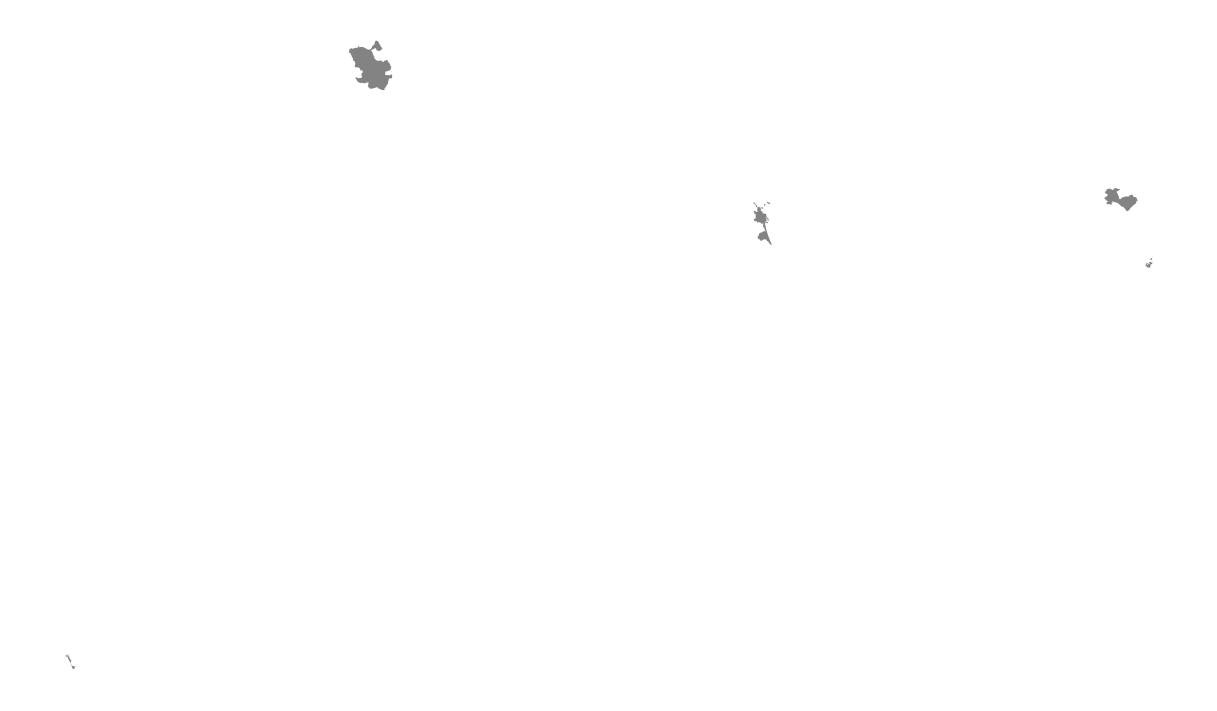

In [32]:
fig, ax = plt.subplots(figsize=(12.058, 10.128), dpi=100,constrained_layout=True)
ecl_ciudades.plot(ax=ax, color="#090808", alpha=.5,zorder=0)

ax.axis('off');

Quatre villes, nous sommes bons. Nous n'avons plus qu'à reprojeter et transformer ces polygones en points en calculant leur centroïde :

In [33]:
ecl_ciudades = ecl_ciudades.to_crs("EPSG:25830")
ecl_ciudades["geometry"] = ecl_ciudades["geometry"].centroid

Et maintenant, nous visualisons avant d'enregistrer cet ultime calque. Remarquez **la présence de la fonction annotate()** afin d'afficher le nom de la ville à proximité de sa localisation.

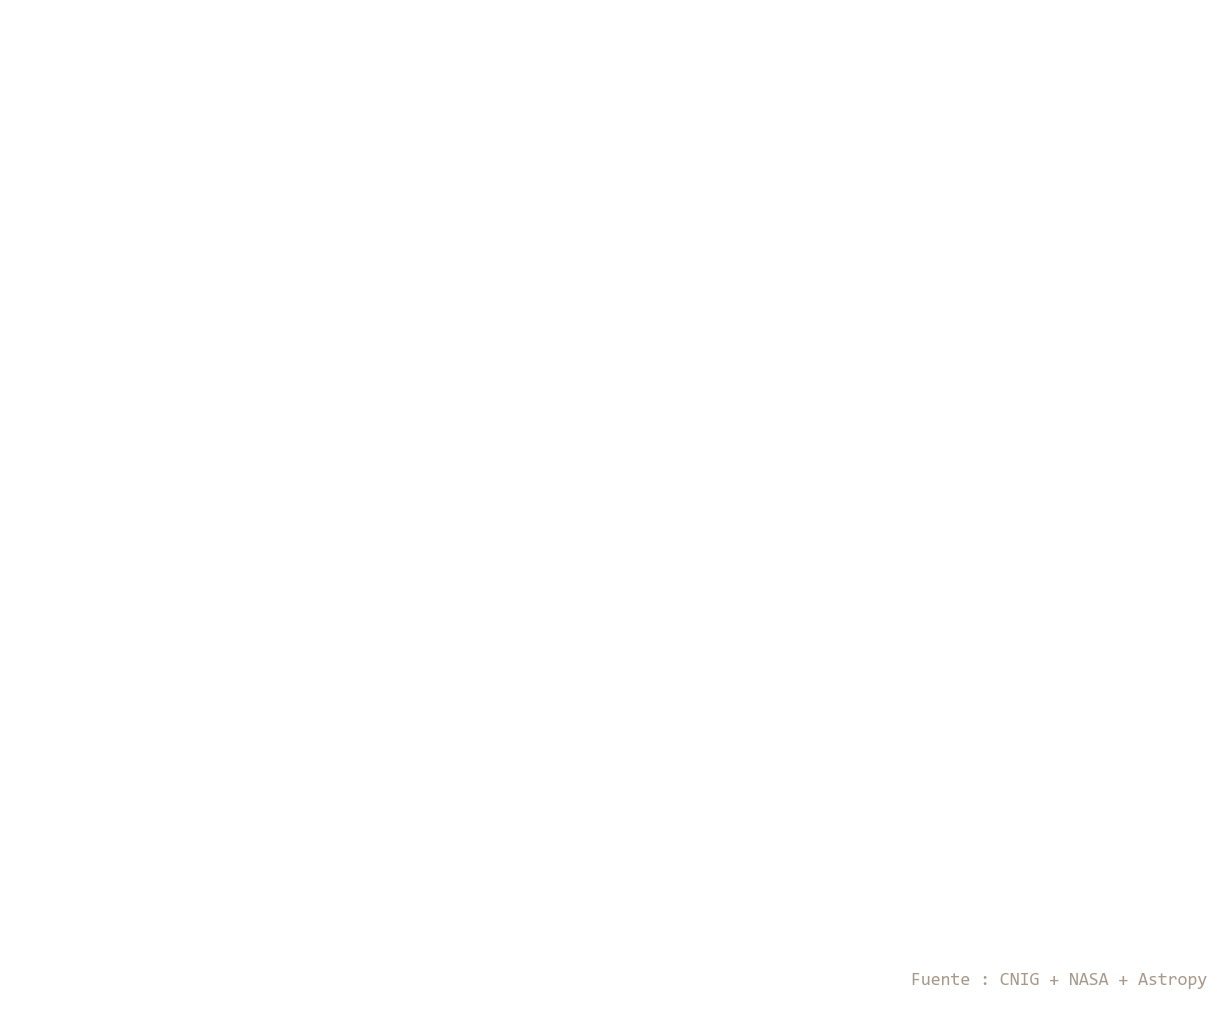

In [34]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Osaka'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default']

fig, ax = plt.subplots(figsize=(12.058, 10.128), dpi=100,constrained_layout=True)

ax.set_ylim(3870655.0131369503,4883505.01313695)
ax.set_xlim(-74125.16131267,1131704.83868733)

for x, y, label in zip(ecl_ciudades.geometry.x, ecl_ciudades.geometry.y, ecl_ciudades.NAMEUNIT):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points",fontsize=13,color="white")

ax.text(850000, 3900000, "Fuente : CNIG + NASA + Astropy",  color="#A8988A", fontsize=13);
ax.axis('off')
plt.savefig('data\\ciudades.png', dpi=1000, transparent=True)

## Superposition finale des calques

Nous atteignons la dernière ligne droite, et allons charger le fond de carte précédent :

In [51]:
res_esp = cv.imread("data\\espagne_16pi.png")
res_esp = cv.cvtColor(res_esp, cv.COLOR_BGR2RGB)
type(res_esp)

numpy.ndarray

Dernière ligne droite, dernière fonction : une superposition de deux images en utilisant OpenCV, qui marche [du moment que les deux illustrations partagent les mêmes dimensions](https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image) :

In [36]:
def composite_png(img_start:np.ndarray,png:str) -> np.ndarray:
    """
        Cette fonction renvoie la superposition de deux images à partir de la bibliothèque OpenCV.
        ATTENTION : pour qu'elle marche, les deux images doivent impérativement être aux mêmes dimensions.
    """
    try:
        img_png = cv.imread(png, cv.IMREAD_UNCHANGED)
        alpha_png = img_png[:, :, 3]/255
        colors_png = img_png[:, :, :3]
        alpha_mask = np.dstack((alpha_png, alpha_png, alpha_png))
        h, w = img_png.shape[:2]
        img_trans = img_start[0:h, 0:w]
        composite = img_trans * (1 - alpha_mask) + colors_png * alpha_mask
        img_start[0:h, 0:w] = composite
        return img_start
    except:
        print("Attention à votre chemin et fichier et/ou format d'image et/ou taille d'images")

Nous allons **augmenter le fond de carte** à partir des calques créés dans ce calepin. **L'ordre a une importance** et nous chargerons d'abord celui des villes afin qu'elles soient masquées par celui des éclipses. La métaphore sera totale !

In [52]:
res_esp = composite_png(res_esp,"data\\ciudades.png")
res_esp = composite_png(res_esp,"data\\eclipsesp.png")

Cette image finale peut désormais être chargée, et augmentée d'un titre :

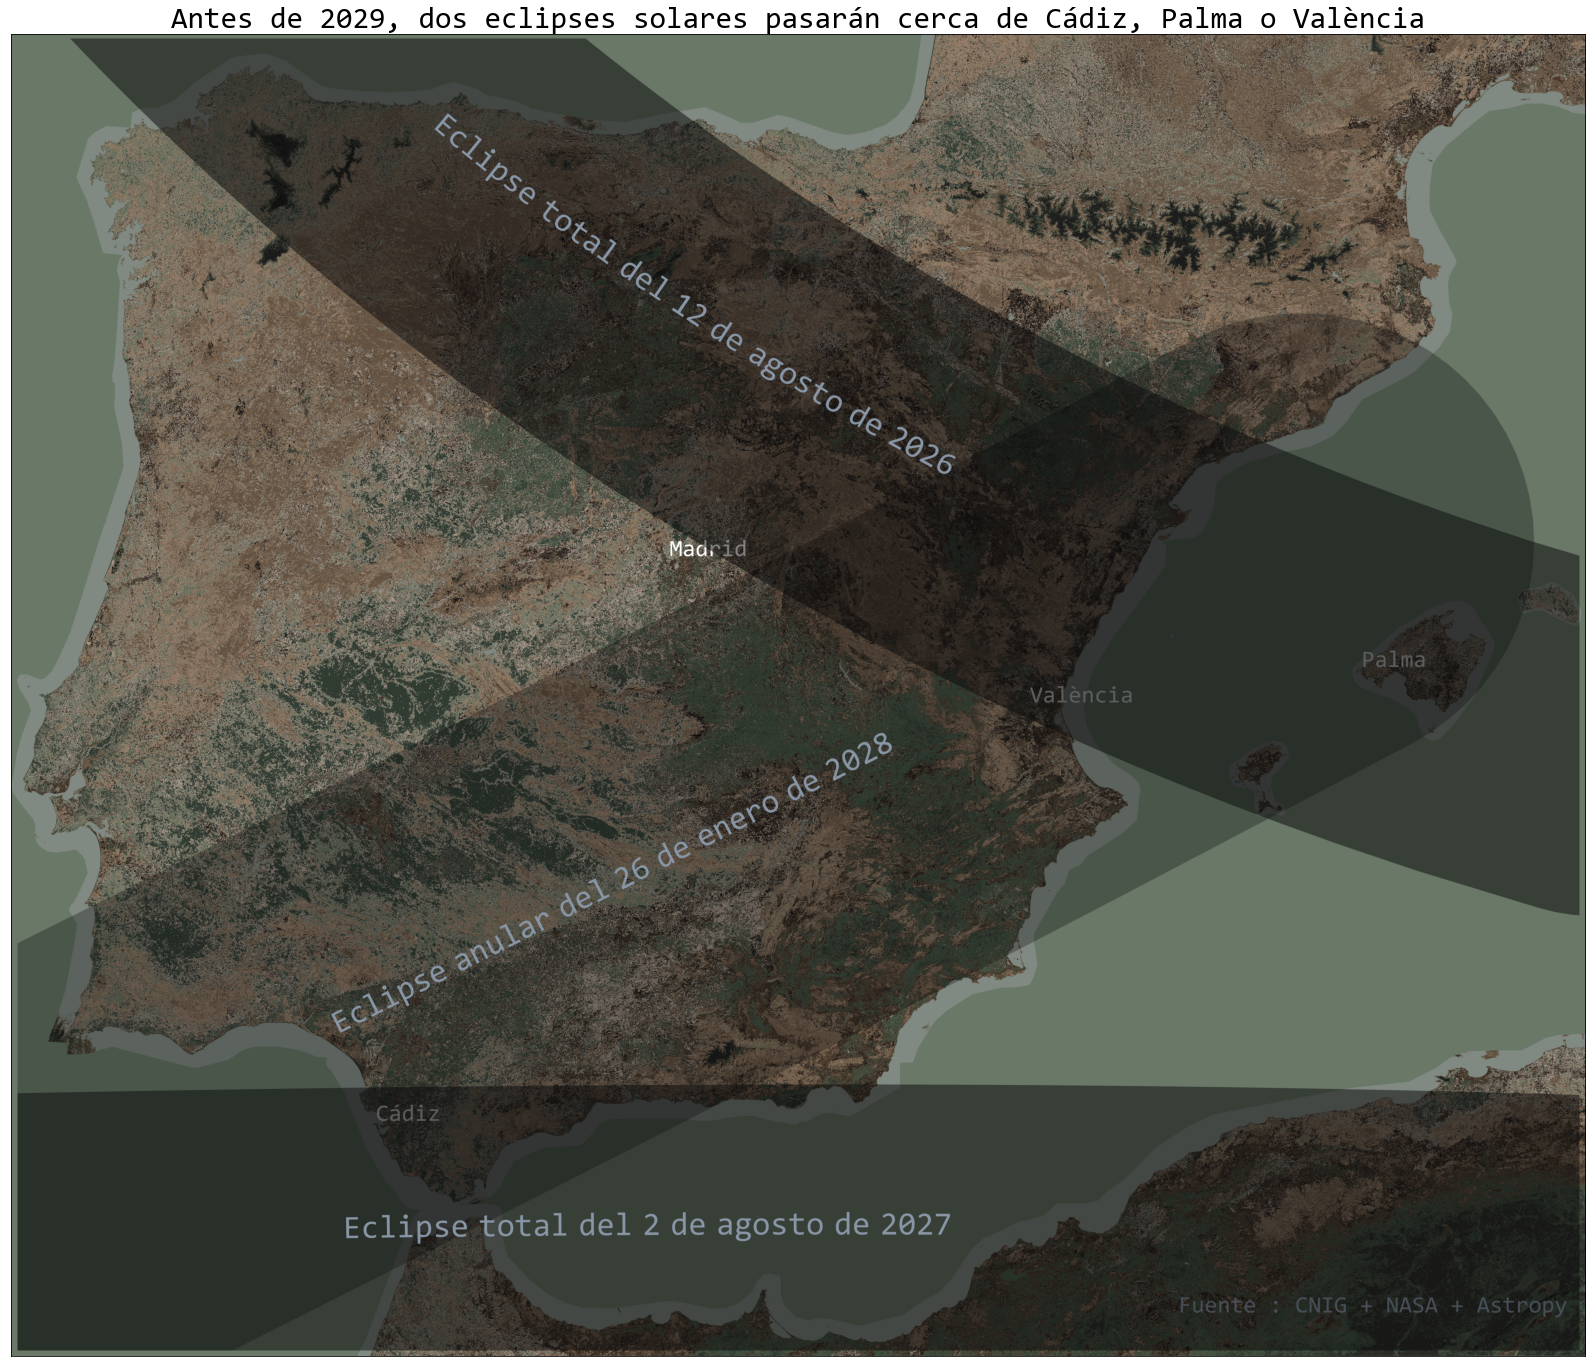

In [53]:
fig, ax = plt.subplots(figsize=(22, 20),constrained_layout=True)
ax.set_title("Antes de 2029, dos eclipses solares pasarán cerca de Cádiz, Palma o València",fontsize=30)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(res_esp)
plt.savefig('data\\eclipses_espana.jpg', dpi=300, bbox_inches = 'tight');